# comparing running and cumulative averages

Attempt at frequentist method of allowing recent games to better inform model versus all-time performance.

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats

import lombardi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
player_data = lombardi.data.demo_players()

In [25]:
start_idx = 16

results = []

for position, data in player_data.iteritems():   
    metric = data['metric']
    x = np.linspace(0, lombardi.data.metric_range(metric), 1000)
    for player in data['players']:

        player_df = lombardi.data.player_df(player, metric)
        performance = list(player_df[metric])

        print position, player

        for week in range(start_idx, len(performance)):

            try:
                samples = {
                    'cumulative': performance[0:week],
                    'running': performance[week-start_idx:week]
                }

                for sample_type, sample_data in samples.iteritems():

                    # compute shape and scale from gamma
                    a,b = lombardi.stats.gamma_params(x, sample_data)

                    # save results
                    results.append({
                        'week': week,
                        'sample': sample_type,
                        'player': player,
                        'metric': metric,
                        'position': position,
                        'yards': performance[week],
                        'shape': a,
                        'scale': b,
                    })
            except Exception, e:
                print e

qb Tom Brady
qb Cam Newton
qb Aaron Rodgers
qb Russell Wilson
qb Drew Brees
qb Matt Ryan
qb Andrew Luck
qb Eli Manning
qb Ryan Tannehill
qb Jay Cutler
qb Matthew Stafford
qb Joe Flacco
wr Antonio Brown
wr Odell Beckham
wr Julio Jones
wr DeAndre Hopkins
wr A.J. Green
wr Dez Bryant
wr Jordy Nelson
wr Mike Evans
wr Alshon Jeffery
wr T.Y. Hilton
wr Randall Cobb
wr Demaryius Thomas
rb Jamaal Charles
rb Adrian Peterson
rb LeSean McCoy
rb Eddie Lacy
rb LeGarrette Blount
rb C.J. Anderson
rb Matt Forte
rb Mark Ingram
rb DeMarco Murray
rb Frank Gore
rb Darren Sproles
rb Todd Gurley


In [26]:
df = pd.DataFrame(results)

In [27]:
df.to_sql('gamma_results', lombardi.data.write_conn, index=False, if_exists='append')

In [44]:
rdf = df[(df['sample'] == 'running') & (df['position'] == 'qb')]
cdf = df[(df['sample'] == 'cumulative') & (df['position'] == 'qb')]

qb running 0.104727548444
qb cumulative 0.0949638913444
rb running 0.188236674152
rb cumulative 0.180388148624
wr running 0.0327498659839
wr cumulative 0.0325315369908


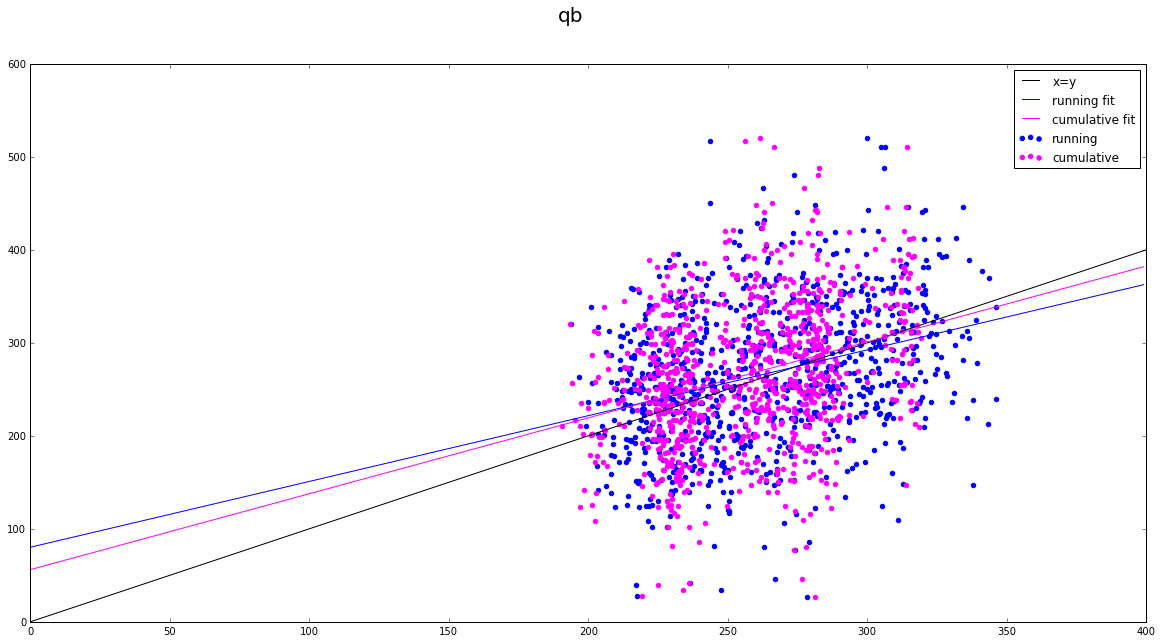

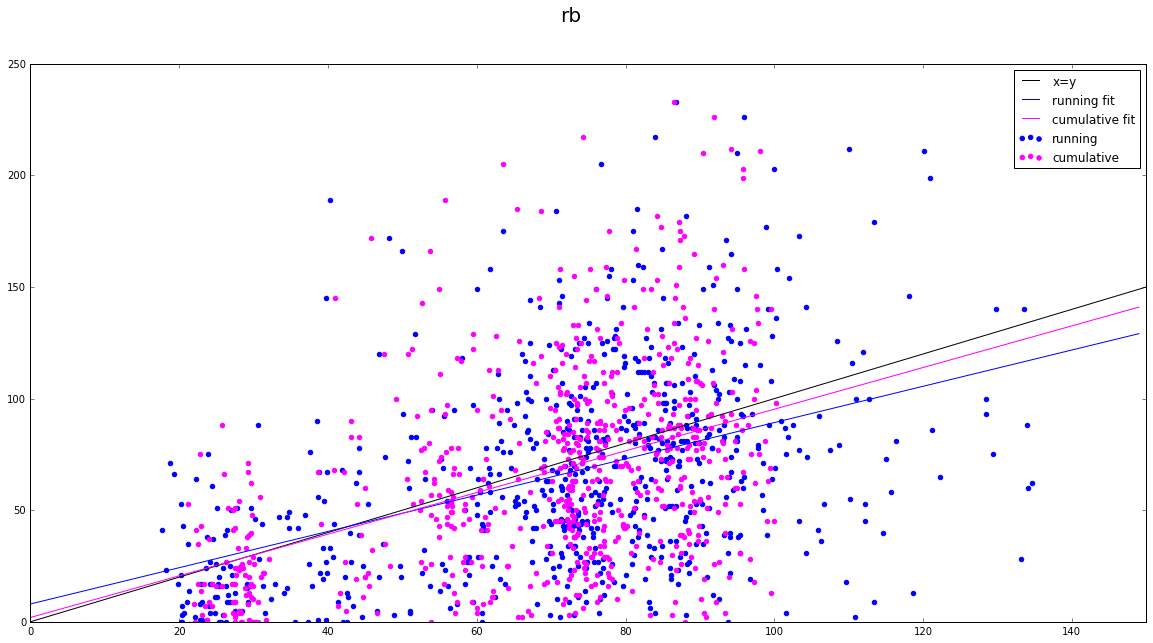

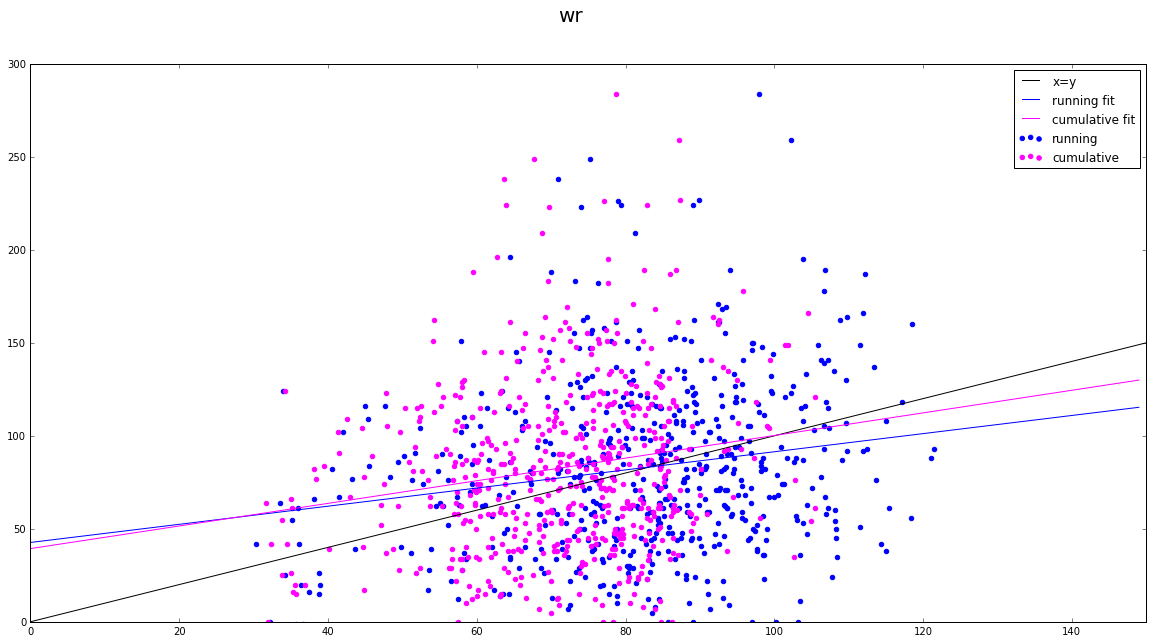

In [67]:
lims = {
    'qb': {
        'x': 400,
        'y': 600
    },
    'rb': {
        'x': 150,
        'y': 250
    },
    'wr': {
        'x': 150,
        'y': 300
    }
}

sample_colors = {
    'cumulative': 'magenta',
    'running': 'blue'
}

for position in ['qb', 'rb', 'wr']:

    fig = plt.figure(figsize=(20,10))
    fig.suptitle(position, size=20)

    x_lim = lims[position]['x']
    y_lim = lims[position]['y']
    
    plt.plot(range(y_lim), range(y_lim), label='x=y', color='black')
    
    for sample in ['running', 'cumulative']:
    
        rdf = df[
            (df['sample'] == sample) & 
            (df['position'] == position)
        ]

        expected_values = rdf['shape']*rdf['scale']
        yards = rdf['yards']

        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(expected_values, yards)
        print position, sample, pow(r_value, 2)
        x = range(x_lim)
        y = [slope * a + intercept for a in x]

        axes = plt.gca()

        axes.set_xlim([0, x_lim])
        axes.set_ylim([0, y_lim])

        plt.scatter(rdf['shape']*rdf['scale'], rdf['yards'], color=sample_colors[sample], label=sample)
        plt.plot(x, y, color=sample_colors[sample], label='{} fit'.format(sample))
        plt.legend()